# Image Classification on the AMD Ryzen™ AI using Timm Xception Model

This notebook provides a practical guide for harnessing the power of AMD Ryzen™ AI for image classification tasks.

- Convert the Timm Xception model to ONNX format using Optimum exporters.
- Quantize the model with the Ryzen AI ONNX Quantizer using Imagenet 1K as the calibration dataset.
- Run inference on a test image using the quantized model.

## Installation

### Ryzen AI Environment setup
A Ryzen AI environment needs to be enabled for the notebook. Please refer to Ryzen AI's [Installation](https://ryzenai.docs.amd.com/en/latest/inst.html) and [Runtime Setup](https://ryzenai.docs.amd.com/en/latest/runtime_setup.html).

### Optimum-AMD library can be installed through pip:
Optimum-AMD provides easy interface for loading and inference of Hugging Face models on Ryzen AI accelerator.

```bash
pip install --upgrade-strategy eager optimum[amd]
```

## Export the model to ONNX

In [1]:
from pathlib import Path
from optimum.exporters.onnx import main_export

In [2]:
model_id = "timm/xception65p.ra3_in1k"

onnx_dir = Path("demo_xception_onnx")
onnx_quantized_dir = Path("demo_xception_onnx_quantized")

In [3]:
main_export(
    model_name_or_path=model_id,
    output=onnx_dir,
    task="image-classification",
    opset=13,
    batch_size=1,
    no_dynamic_axes=True,
)

Framework not specified. Using pt to export the model.
Using the export variant default. Available variants are:
    - default: The default ONNX variant.
Using framework PyTorch: 2.1.2+cpu
Post-processing the exported models...
Weight deduplication check in the ONNX export requires accelerate. Please install accelerate to run it.
Validating ONNX model demo_xception_onnx/model.onnx...
	-[✓] ONNX model output names match reference model (logits)
	- Validating ONNX Model output "logits":
		-[✓] (1, 1000) matches (1, 1000)
		-[✓] all values close (atol: 0.001)
The ONNX export succeeded and the exported model was saved at: demo_xception_onnx


## Quantize the model

Quantization tool takes the onnx float32 model and produce a quantized model. For different hardware platforms, distinct quantization settings are required to optimize compatibility with hardware accelerators.

For IPU, acceleration is achieved using QDQ quantization with uint8 activation, int8 weight types, and power of 2 scale

In [4]:
from functools import partial

import timm

from transformers import PretrainedConfig
from optimum.amd.ryzenai import RyzenAIOnnxQuantizer, AutoQuantizationConfig

In [5]:
# Preprocess configuration and data transformations
config = PretrainedConfig.from_pretrained(onnx_dir)
data_config = timm.data.resolve_data_config(pretrained_cfg=config.pretrained_cfg)
transforms = timm.data.create_transform(**data_config, is_training=False)

def preprocess_fn(ex, transforms):
    image = ex["image"]
    if image.mode == "L":
        # Convert greyscale to RGB if needed
        print("WARNING: converting greyscale to RGB")
        image = image.convert("RGB")
    pixel_values = transforms(image)
    return {"pixel_values": pixel_values}

In [6]:
# Initialize the RyzenAIOnnxQuantizer with the exported model
quantizer = RyzenAIOnnxQuantizer.from_pretrained(onnx_dir)

In [7]:
# Load recommended quantization config for model
quantization_config = AutoQuantizationConfig.ipu_cnn_config()
quantization_config

QuantizationConfig(format=<QuantFormat.QDQ: 1>, calibration_method=<PowerOfTwoMethod.MinMSE: 1>, activations_dtype=<QuantType.QUInt8: 1>, activations_symmetric=True, weights_dtype=<QuantType.QInt8: 0>, weights_symmetric=True, enable_dpu=True)

In [8]:
# Obtain a calibration dataset for computing quantization parameters
train_calibration_dataset = quantizer.get_calibration_dataset(
    "imagenet-1k",
    preprocess_function=partial(preprocess_fn, transforms=transforms),
    num_samples=100,
    dataset_split="train",
    preprocess_batch=False,
    streaming=True,
)

C:\Users\Mohit\anaconda3\envs\optimumhamdhfv101_jan19\lib\site-packages\datasets\load.py:1429: FutureWarning: The repository for imagenet-1k contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/imagenet-1k
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [9]:
# Run the quantizer with the specified configuration and calibration data
quantizer.quantize(
    quantization_config=quantization_config,
    dataset=train_calibration_dataset,
    save_dir=onnx_quantized_dir
)

Quantizing model...


[VAI_Q_ONNX_INFO]: Time information:
2024-01-24 17:19:32.080446
[VAI_Q_ONNX_INFO]: OS and CPU information:
                                        system --- Windows
                                          node --- LAPTOP-9LOS1RK9
                                       release --- 10
                                       version --- 10.0.22621
                                       machine --- AMD64
                                     processor --- AMD64 Family 25 Model 116 Stepping 1, AuthenticAMD
[VAI_Q_ONNX_INFO]: Tools version information:
                                        python --- 3.9.18
                                          onnx --- 1.15.0
                                   onnxruntime --- 1.15.1
                                    vai_q_onnx --- 1.16.0+e38e0c6
[VAI_Q_ONNX_INFO]: Quantized Configuration information:
                                   model_input --- demo_xception_onnx/model.onnx
                                  model_output --- demo_xception_onnx

INFO:vai_q_onnx.quant_utils:The input ONNX model demo_xception_onnx/model.onnx can create InferenceSession successfully
INFO:vai_q_onnx.quantize:Removed initializers from input
INFO:vai_q_onnx.quantize:Loading model...
INFO:vai_q_onnx.quantize:enable_dpu is True, optimize the model for better hardware compatibility.
INFO:vai_q_onnx.optimize:Found BatchNormalization node /blocks/blocks.1/norm/BatchNormalization. Replacing with Conv.
INFO:vai_q_onnx.optimize:Found BatchNormalization node /blocks/blocks.2/norm/BatchNormalization. Replacing with Conv.
INFO:vai_q_onnx.optimize:Found BatchNormalization node /blocks/blocks.3/norm/BatchNormalization. Replacing with Conv.
INFO:vai_q_onnx.optimize:Found BatchNormalization node /blocks/blocks.4/norm/BatchNormalization. Replacing with Conv.
INFO:vai_q_onnx.optimize:Found BatchNormalization node /blocks/blocks.5/norm/BatchNormalization. Replacing with Conv.
INFO:vai_q_onnx.optimize:Found BatchNormalization node /blocks/blocks.6/norm/BatchNormalizat

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Op Type              ┃ Float Model                                       ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Conv                 │ 132                                               │
│ Relu                 │ 65                                                │
│ Add                  │ 20                                                │
│ BatchNormalization   │ 20                                                │
│ GlobalAveragePool    │ 1                                                 │
│ Flatten              │ 1                                                 │
│ Gemm                 │ 1                                                 │
├──────────────────────┼───────────────────────────────────────────────────┤
│ Quantized model path │ demo_xception_onnx_quantized/model_quantized.onnx │
└──────────────────────┴───────────────────────────────────────────────────┘

Saved quantized model at: demo_xception_onnx_quantized
Configuration saved in demo_xception_onnx_quantized\ryzenai_config.json


WindowsPath('demo_xception_onnx_quantized')

## Run inference using the quantized model

In [10]:
import torch
from PIL import Image
import requests
from optimum.amd.ryzenai import RyzenAIModelForImageClassification
from datasets import load_dataset

model = RyzenAIModelForImageClassification.from_pretrained(onnx_quantized_dir, vaip_config="vaip_config.json")

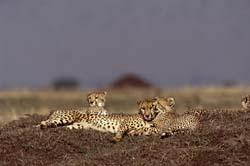

In [11]:
url = "https://datasets-server.huggingface.co/assets/imagenet-1k/--/014711311cec8b5959350c373878a3311caeb764/--/default/test/37/image/image.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [12]:
output = model(transforms(image).unsqueeze(0)).logits
top5_probabilities, top5_class_indices = torch.topk(torch.softmax(output, dim=1) * 100, k=5)

In [13]:
test_dataset = load_dataset("imagenet-1k", split="test", streaming=True, trust_remote_code=True)
labels = test_dataset.features['label'].names
for i in range(len(top5_class_indices[0])):
    index = top5_class_indices[0][i]
    probability = top5_probabilities[0][i]
    class_label = labels[index]
    print(f"Top {i+1} Class: {class_label}, Probability: {probability:.2f}%")

Top 1 Class: cheetah, chetah, Acinonyx jubatus, Probability: 71.55%
Top 2 Class: leopard, Panthera pardus, Probability: 2.30%
Top 3 Class: jaguar, panther, Panthera onca, Felis onca, Probability: 0.96%
Top 4 Class: gazelle, Probability: 0.18%
Top 5 Class: lion, king of beasts, Panthera leo, Probability: 0.15%
